<a href="https://colab.research.google.com/github/aadarsh0709/gnnmodelpfas/blob/main/gnnidsmilesgraphconversion0107.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch.geometric
!pip install rdkit
!pip install pubchempy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.2/34.2 MB 62.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=5a35fc484cef439ac5f28f146724ebde8eb1ffc4abe8fcc202cbdd91fea3fb1a
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [ ]:
import pandas as pd
import torch
from torch_geometric.data import Data, Dataset
from sklearn.model_selection import train_test_split
from rdkit import Chem
import requests
import matplotlib.pyplot as plt


#Read the CSV file
df = pd.read_csv('https://raw.githubusercontent.com/aadarsh0709/gnnmodelpfas/refs/heads/main/S3_Dawsonetal_PFAS_HL_101122.csv')

# Preprocessing

In [ ]:
#Get the atom features (Node)
def atom_features(atom):
    return torch.tensor([
        atom.getMass(),
        atom.GetTotalNumHs(),
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        atom.GetNumRadicalElectrons(),
        int(atom.GetChiralTag()),
        int(atom.GetIsAromatic()),
        int(atom.IsInRing()),
    ], dtype=torch.float32)

#Get the bond features (Edge)
def bond_features(bond):
    return torch.tensor([
        int(bond.GetBondType()),
        int(bond.GetIsConjugated()),
        int(bond.IsInRing()),
        int(bond.GetBondDir())
    ], dtype=torch.float32)


In [ ]:
import pubchempy as pcp

def get_smiles_by_cas(cas_number):
    """
    Retrieves the SMILES string for a given CAS number using PubChem.

    Parameters:
        cas_number (str): The CAS number of the compound.

    Returns:
        str: The corresponding SMILES string if found, otherwise an error message.
    """
    try:
        # Search for compounds using the CAS number
        compounds = pcp.get_compounds(cas_number, 'name')
        if not compounds:
            return "Not Found"

        # Retrieve the SMILES string of the first matched compound
        compound = compounds[0]
        return [ compound.exact_mass, compound.isomeric_smiles]
    except Exception as e:
        # Return the error message in case of an exception
        return f"Error: {e}"

In [ ]:
#pull list of unique casrns
unique_casrns = list(df["CASRN"].unique())
smiles_dict = {}
mass_dict = {}
count=0
print("# of unique casrns= {}",len(unique_casrns))

# of unique casrns= {} 6603


In [ ]:
# Iterate through unique CASRNs and get SMILES

for casrn in unique_casrns:
    smilesandmass =  get_smiles_by_cas(casrn)
    smiles_dict[casrn] = smilesandmass[1]
    mass_dict[casrn] =  smilesandmass[0]
    if (count%100 ==0 ):
        print ( count )
    count +=1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600


In [ ]:
#Add the SMILES column to the DataFrame
df['SMILES'] = df['CASRN'].map(smiles_dict)
df['MASS'] = df['CASRN'].map(mass_dict)

#Remove the parts where the CASRN has no SMILES in the DataFrame
df = df[(df['SMILES'].notna()) & (df['SMILES'] != 'Not Found')]

unique_casrns_count = df['CASRN'].nunique()
print(f"Number of unique CASRNs: {unique_casrns_count}")

missing_smiles = df[df['SMILES'].isnull()]
print("CASRNs with missing SMILES:")
print(missing_smiles[['CASRN']])


Number of unique CASRNs: 6603
CASRNs with missing SMILES:
Empty DataFrame
Columns: [CASRN]
Index: []


In [ ]:
#Convert the smiles information into graph format utilizing torch and setting the lists
def smiles_to_graph(smiles_string):
    """
    Converts a SMILES string into a PyTorch Geometric Data object representing a molecular graph.

    Args:
        smiles_string (str): The SMILES string representing a molecule.

    Returns:
        Data: A PyTorch Geometric Data object containing node features, edge indices, and edge features.
    """
    if not smiles_string:  # Check if smiles is None or empty
        return None  # Return None if SMILES is invalid

    molecule = Chem.MolFromSmiles(smiles_string)
    if molecule is None:  # Check if RDKit failed to create a molecule
      return None  # Return None if conversion failed

    # Node features (atom types)
    num_atoms = molecule.GetNumAtoms()
    node_features = []
    for atom in molecule.GetAtoms():
        node_features.append([atom.GetAtomicNum()])  # Example: atomic number as feature

    # Edge features (bond types)
    edges = []
    edge_features = []
    for bond in molecule.GetBonds():
        start_node = bond.GetBeginAtomIdx()
        end_node = bond.GetEndAtomIdx()
        edges.append([start_node, end_node])
        edges.append([end_node, start_node])  # For undirected graph
        edge_features.append([bond.GetBondType()])
        edge_features.append([bond.GetBondType()])

    # Convert to tensors
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
    return graph_data


def smiles_to_graph1(smiles):

    if not smiles:  # Check if smiles is None or empty
        return None  # Return None if SMILES is invalid

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:  # Check if RDKit failed to create a molecule
        return None  # Return None if conversion failed

    atom_feats = torch.stack([atom_features(atom) for atom in mol.GetAtoms()])

    edge_indices = []
    edge_feats = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_indices += [[i, j], [j, i]]
        edge_feats += [bond_features(bond)] * 2

    edge_index = torch.tensor(edge_indices).t().contiguous()
    edge_attr = torch.stack(edge_feats) if edge_feats else None

    return Data(x=atom_feats, edge_index=edge_index, edge_attr=edge_attr)


In [ ]:
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer

binsize=5

# K-means binning
kmeans_binner = KBinsDiscretizer(n_bins=binsize, encode='ordinal', strategy='kmeans', random_state =0)
df['kmeans_bin'] = kmeans_binner.fit_transform(df[['HalfLife.h']])


# Quantile-based binning
quantile_binner = KBinsDiscretizer(n_bins=binsize, encode='ordinal', strategy='quantile', random_state =0)
df['quantile_bin'] = quantile_binner.fit_transform(df[['HalfLife.h']])

In [ ]:
import typing

def one_hot_encode(items: list) -> typing.List[list]:
    results = []
    # find the unique items (we want to unique items b/c duplicate items will have the same encoding)
    unique_items = list(set(items))
    # sort the unique items
    sorted_items = sorted(unique_items)
    # find how long the list of each item should be
    max_index = len(unique_items)

    for item in items:
        # create a list of zeros the appropriate length
        one_hot_encoded_result = [0 for i in range(0, max_index)]
        # find the index of the item
        one_hot_index = sorted_items.index(item)
        # change the zero at the index from the previous line to a one
        one_hot_encoded_result[one_hot_index] = 1
        # add the result
        results.append(one_hot_encoded_result)

    return results

df["Species"] = one_hot_encode(df["Species"])
df["Sex"] = one_hot_encode(df["Sex"])
df["DosingAdj"] = one_hot_encode(df["DosingAdj"])

In [ ]:
#Grouping of Data based on species

#Getting a list of all of the species
df["string_spc"] = df["Species"].astype(str)
species_list = df['string_spc'].unique()
#Printing the species list
print(species_list)
#Group data based off species
grouped_data = df.groupby('string_spc')
#Iterate through the species split data
"""
for species, group in grouped_data:
    print(f"Species: {species}")
    print(group)
    print("\n")
"""

['[1, 0, 0, 0, 0, 0, 0, 0, 0]' '[0, 1, 0, 0, 0, 0, 0, 0, 0]'
 '[0, 0, 1, 0, 0, 0, 0, 0, 0]' '[0, 0, 0, 1, 0, 0, 0, 0, 0]'
 '[0, 0, 0, 0, 1, 0, 0, 0, 0]' '[0, 0, 0, 0, 0, 1, 0, 0, 0]'
 '[0, 0, 0, 0, 0, 0, 1, 0, 0]' '[0, 0, 0, 0, 0, 0, 0, 1, 0]'
 '[0, 0, 0, 0, 0, 0, 0, 0, 1]']


'\nfor species, group in grouped_data:\n    print(f"Species: {species}")\n    print(group)\n    print("\n")\n'

In [ ]:
#For each of the species group split into train and test data

#Set the lists for both train and test
train_data = []
test_data = []

#For loop that will iterate through the species in order to split the data
for Species,group in grouped_data:
    train_group, test_group = train_test_split(group, test_size=0.2, random_state=42)
    train_data.append(train_group)
    test_data.append(test_group)

#Combination of the split data
train_set = pd.concat(train_data)
test_set = pd.concat(test_data)


#Test if training and testing set properly function
print("Training data set count=",train_set.size)
print("Training data set count=",test_set.size)

Training data set count= 4849182
Training data set count= 1212372


In [ ]:
train_set.to_csv("train.csv")
test_set.to_csv("test.csv")

Number of unique CASRNs: 6603
CASRNs with missing SMILES:
Empty DataFrame
Columns: [CASRN]
Index: []


# Modeling

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pandas.plotting import table
from rdkit.Chem import Draw
from rdkit import Chem
from sklearn.metrics import r2_score
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import to_networkx
from torch.nn import Linear

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pubchempy
import rdkit
import time
import torch
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import torch
from torch_geometric.data import Dataset
from tqdm import tqdm

class MoleculeDatasetMemory(Dataset):
    def __init__(self, root, dataframe, bin_type, transform=None, pre_transform=None, pre_filter=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.bin_type = bin_type
        self.data_list = []  # Store all processed data in memory
        super().__init__(root, transform, pre_transform, pre_filter)

        self._load_processed_data()

    @property
    def raw_file_names(self):
        return []  # We don't have raw files as we're using a dataframe

    @property
    def processed_file_names(self):
        return ['memory_dataset.pt']  # We'll save the entire dataset as one file

    def download(self):
        pass  # We don't need to download anything

    def process(self):
        for idx, row in tqdm(self.dataframe.iterrows(), total=self.dataframe.shape[0]):
            smiles = row['SMILES']
            graph = smiles_to_graph(smiles)
            if graph is not None:  # Only process valid graphs
                c_name = self._get_column_name()
                graph.y = torch.tensor([float(row[c_name])], dtype=torch.float32)
                graph.species = torch.tensor(row['Species'], dtype=torch.float)
                graph.sex = torch.tensor(row['Sex'], dtype=torch.float)
                graph.dosing_adj = torch.tensor(row['DosingAdj'], dtype=torch.float)
                self.data_list.append(graph)

        # Save the entire dataset to a single file
        torch.save(self.data_list, os.path.join(self.processed_dir, 'memory_dataset.pt'))

    def len(self):
        return len(self.data_list)

    def _load_processed_data(self):
        if os.path.exists(self.processed_paths[0]):
            print("Loading preprocessed dataset from file.")
            self.data_list = torch.load(self.processed_paths[0])
        else:
            print("Preprocessed dataset not found. It will be created when accessing data.")

    def get(self, idx):
        return self.data_list[idx]

    def _get_column_name(self):
        if self.bin_type == 'raw':
            return 'HalfLife.h'
        elif self.bin_type in ['kmeans_bin', 'equal_width_bin', 'quantile_bin', "half_life_binned"]:
            return self.bin_type
        else:
            raise ValueError(f"Unknown bin_type: {self.bin_type}")

In [7]:
import pandas as pd
import numpy as np
from torch_geometric.loader import DataLoader

train_set = pd.read_csv("/content/drive/MyDrive/train.csv")
test_set = pd.read_csv("/content/drive/MyDrive/test.csv")

train_dataset2 = MoleculeDatasetMemory("/content/drive/MyDrive/traindatafinal_newmemory", train_set, 'kmeans_bin')
test_dataset2 = MoleculeDatasetMemory("/content/drive/MyDrive/testdatafinal_newmemory", test_set, 'kmeans_bin')


Loading preprocessed dataset from file.
Loading preprocessed dataset from file.


In [8]:
from re import X
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_mean_pool
from torch.nn import Sequential, Linear, ReLU
import ast

# Calculate accuracy r2
def r2_accuracy(pred_y, y):
    score = r2_score(y, pred_y)
    return round(score, 2)*100


class GCN(torch.nn.Module):

    def __init__(self, num_node_features, hidden_channels, num_classes=10):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        # Linear layers for graph-level features
        self.species_lin = torch.nn.Linear(9, hidden_channels)
        self.sex_lin = torch.nn.Linear(2, hidden_channels)
        self.dosing_adj_lin = torch.nn.Linear(3, hidden_channels)

        self.lin = torch.nn.Linear(hidden_channels * 4, num_classes)


    def forward(self, x, edge_index, batch, species, sex, dosing_adj):

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)
        species_emb = F.relu(self.species_lin(species.view(-1, 9)))
        sex_emb = F.relu(self.sex_lin(sex.view(-1, 2)))
        dosing_adj_emb = F.relu(self.dosing_adj_lin(dosing_adj.view(-1, 3)))

        x = torch.cat([x, species_emb, sex_emb, dosing_adj_emb], dim=1)
        x = F.dropout(x, p=0.5, training=self.training)

        # Classifier (Linear).
        x = self.lin(x)

        return x

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        out = model(data.x, data.edge_index, data.batch,
                    data.species, data.sex, data.dosing_adj)

        #new code
        #loss = loss_fn(pred, data.y)
        loss = criterion(out, data.y.long())
        pred = out.argmax(dim=1)
        correct = (pred == data.y).sum().item()
        total = data.y.size(0)
        acc = (correct / total)*100

        loss.backward()
        optimizer.step()

    return loss, acc, pred, data.y, out

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch,
                    data.species, data.sex, data.dosing_adj)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    return correct / total

In [ ]:
pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2

In [9]:
from torch_geometric.data import DataLoader
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
import time


# Data generated
embeddings = []
losses = []
accuracies = []
outputs = []
targets = []

# Model initialization
num_node_features = train_dataset2.get(1).num_node_features
num_graph_features = 5
num_edge_features = train_dataset2.get(1).num_edge_features
hidden_channels = 64
num_classes = 10

model = GCN(num_node_features, hidden_channels, num_classes)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)


# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()



# Use GPU for training, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Data loader
NUM_GRAPHS_PER_BATCH = 2058
NUM_EPOCHS = 150

train_loader2 = DataLoader(train_dataset2, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True, num_workers = 32, pin_memory=True)
test_loader2 = DataLoader(test_dataset2, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True, num_workers = 32, pin_memory=True)


print('\n======== data distribution =======\n')
print("Size of training data: {} graphs".format(len(train_dataset2)))
print("Size of testing data: {} graphs".format(len(test_dataset2)))


print('\n======== Starting training ... =======\n')
start_time = time.time()

losses = []
for epoch in range(NUM_EPOCHS):
    loss, acc, pred, target, h = train(model, train_loader2, optimizer, criterion, device)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(pred)
    targets.append(target)

    if epoch % 10 == 0:
      # print(f"Epoch {epoch} | Train Loss {loss}")
      print(f'Epoch {epoch:>3} | Loss: {loss:.5f} | Acc: {acc:.2f}%')

print("\nTraining done!\n")
elapsed = time.time() - start_time
minutes_e = elapsed//60
print("--- training took:  %s minutes ---" % (minutes_e))

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (species_lin): Linear(in_features=9, out_features=64, bias=True)
  (sex_lin): Linear(in_features=2, out_features=64, bias=True)
  (dosing_adj_lin): Linear(in_features=3, out_features=64, bias=True)
  (lin): Linear(in_features=256, out_features=10, bias=True)
)
Number of parameters:  12490

======== data distribution =======

Size of training data: 279585 graphs
Size of testing data: 69903 graphs

======== Starting training ... =======

Epoch   0 | Loss: 0.75902 | Acc: 66.32%
Epoch  10 | Loss: 0.60147 | Acc: 75.61%
Epoch  20 | Loss: 0.50243 | Acc: 80.17%
Epoch  30 | Loss: 0.45976 | Acc: 82.17%
Epoch  40 | Loss: 0.47833 | Acc: 82.74%
Epoch  50 | Loss: 0.49116 | Acc: 82.11%
Epoch  60 | Loss: 0.49083 | Acc: 81.20%
Epoch  70 | Loss: 0.49239 | Acc: 81.08%
Epoch  80 | Loss: 0.48224 | Acc: 80.51%
Epoch  90 | Loss: 0.49648 | Acc: 80.97%
Epoch 100 | Loss: 0.46102 | Acc: 82.74%
Epoch 110 | Loss: 0.49977 | Acc: 

In [10]:
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
losses_np = np.array([x.item() for x in losses])
outs = [i[0] for i in outputs]
outputs_np = np.array([x.item() for x in outs])
targs = [i[0] for i in targets]
targets_np = np.array([x.item() for x in targs])

results = pd.concat([pd.DataFrame(losses_np),
                     pd.DataFrame(accuracies),
                     pd.DataFrame(outputs_np),
                     pd.DataFrame(targets_np)], axis= 1)
results.columns = ['losses', 'accuracy', 'pred', 'target']
results.head()

,losses,accuracy,pred,target
0,0.759018,66.324786,3,3.0
1,0.657096,73.048433,0,1.0
2,0.663343,73.675214,1,3.0
3,0.600349,75.156695,2,2.0
4,0.613021,75.384615,0,1.0


In [12]:
ymin, ymax = np.floor(min(results[[ 'pred', 'target']].min())),\
    round(max(results[[ 'pred', 'target']].max()))

# all training
training_acc = r2_accuracy(results["target"], results["pred"])

#first 20 epochs
training_acc_1st_20 = r2_accuracy(results["target"][:20], results["pred"][:20])

# last 20 epochs
training_acc_last_20 = r2_accuracy(results["target"][-20:], results["pred"][-20:])

print("Training accuracy: {}%".format(round(training_acc, 2)))
print("1st 20 Training accuracy: {}%".format(round(training_acc_1st_20, 2)))
print("Last 20 Training accuracy: {}%".format(round(training_acc_last_20, 2)))

Training accuracy: 39.0%
1st 20 Training accuracy: 41.0%
Last 20 Training accuracy: 23.0%


FileNotFoundError: [Errno 2] No such file or directory: '/content/assets/images/pred_vs_targ.png'

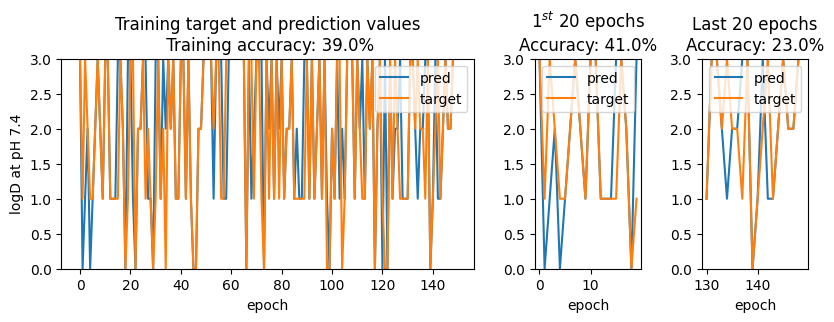

In [13]:
import matplotlib.pyplot as plt

# creating grid for subplots
fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot2grid(shape=(2, 28), loc=(0,0), colspan=15)
ax2 = plt.subplot2grid(shape=(2, 28), loc=(0,17), colspan=4)
ax3 = plt.subplot2grid(shape=(2, 28), loc=(0,23), colspan=4)


results[[ 'pred', 'target']].plot(title='Training target and prediction values\n Training accuracy: ' + str(round(training_acc, 2) )+ '%',
                                  xlabel='epoch', ylabel = 'logD at pH 7.4', ax=ax1, ylim = (ymin, ymax) )
results[[ 'pred', 'target']][:20].plot(title="$1^{st}$ 20 epochs\nAccuracy: " + str(round(training_acc_1st_20, 2)) +'%',
                                       xlabel='epoch', ax=ax2, ylim = (ymin, ymax))
results[[ 'pred', 'target']][-20:].plot(title="Last 20 epochs\nAccuracy: " + str(round(training_acc_last_20, 2)) +'%',
                                       xlabel='epoch', ax=ax3, ylim = (ymin, ymax))
fig.savefig('assets/images/pred_vs_targ.png', bbox_inches='tight')

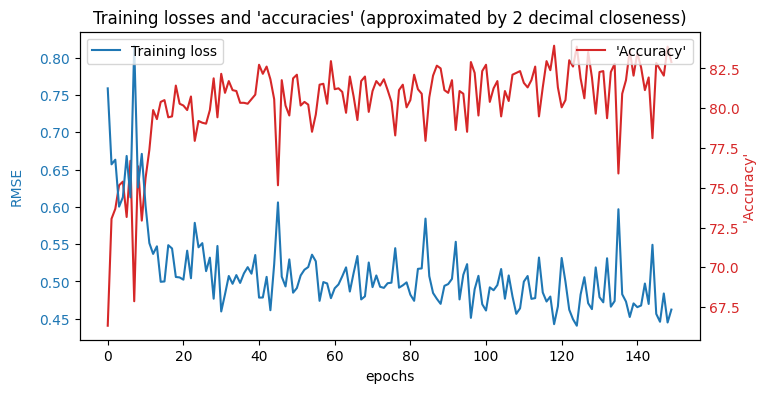

FileNotFoundError: [Errno 2] No such file or directory: '/content/assets/images/losses_and_accuracies.png'

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax1 = plt.subplots(figsize=(8,4))

color1 = 'tab:red'
ax1.set_xlabel('epochs')

ax1.tick_params(axis='y', labelcolor=color1)
sns.lineplot(data=results.accuracy, label="'Accuracy'", color=color1, ax=ax1)
plt.legend(loc='upper right')

ax2 = ax1.twinx()

color2 = 'tab:blue'
ax1.set_ylabel('RMSE' , color=color2, labelpad=40)
ax2.set_ylabel("'Accuracy'", color=color1, labelpad=30)

ax2.tick_params(axis='y', labelcolor=color2)
sns.lineplot(data=losses_float, label='Training loss', color=color2, ax=ax2)
plt.legend(loc='upper left')

ax1.yaxis.tick_right()
ax2.yaxis.tick_left()

plt.title("Training losses and 'accuracies' (approximated by 2 decimal closeness)")

plt.show()
fig.tight_layout()
fig.savefig('assets/images/losses_and_accuracies.png', bbox_inches='tight')

In [19]:
import pandas as pd

# One batch prediction
test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["real"] = df["y"].apply(lambda row: row[0])
df["pred"] = df["y_pred"].apply(lambda row: row[0])
df.head()


[[2.4740476608276367, 3.347126007080078, 7.110254764556885, 2.7714638710021973, -3.343214511871338, -3.3432087898254395, -3.3432250022888184, -3.343229055404663, -3.3432300090789795, -3.3432247638702393], [1.9559615850448608, 3.1277191638946533, 3.764613628387451, 2.6717777252197266, -2.4608840942382812, -2.4608845710754395, -2.460883855819702, -2.460883617401123, -2.460883855819702, -2.460883378982544], [5.407837390899658, 5.874184608459473, 5.05401611328125, -1.8454946279525757, -3.029000759124756, -3.0290026664733887, -3.02899432182312, -3.028991222381592, -3.0289905071258545, -3.028994083404541], [0.23453180491924286, 5.482281684875488, 2.3988730907440186, 4.849672317504883, -2.7982778549194336, -2.79827880859375, -2.798274517059326, -2.7982728481292725, -2.7982726097106934, -2.7982747554779053], [1.0882155895233154, 0.9989514350891113, 4.356334686279297, 3.045778751373291, -2.0162291526794434, -2.0162248611450195, -2.016238212585449, -2.0162417888641357, -2.016242504119873, -2.016